# Unified Model with Multiple Strategic Agents: Strategic Agent-Specific Message Weights

James Yu, 19 November 2022

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

Starting to implement some of the new improvements in the solver.

In [2]:
def M(K, B, R, L, delta):
    """Computes M_{t-1} given B_l \forall l, K_t^l \forall l, 
        R_l \forall l, number of strategic agents L, and delta."""
    # handle the generic structure first, with the correct pairings:
    base = [[B[l_prime].T @ K[l_prime] @ B[l] for l in range(L)] for l_prime in range(L)]
    # then change the diagonals to construct M_{t-1}:
    for l in range(L): base[l][l] = B[l].T @ K[l] @ B[l] + R[l]/delta
    return np.block(base)

def H(B, K, A, L):
    """Computes H_{t-1} given B_l \forall l, K_t^l \forall l, 
        A, and number of strategic agents L."""
    return np.concatenate(tuple(B[l].T @ K[l] @ A for l in range(L)), axis = 0)

def C_l(A, B, K, k, h, L, c, x, n):
    """Computes C_{t-1}^h (displayed as C_{t-1}^l) given A, B_l \forall l, K_t^l \forall l, 
        k_t^l \forall l, a specific naive agent h, number of strategic agents L, 
        c_l \forall l, x_l \forall l, and number of naive agents n"""
    return np.concatenate(tuple(B[l].T @ K[l] @ A @ ((x[h] - x[l]) * np.ones((n, 1))) 
                           + B[l].T @ K[l] @ c[l] 
                           + 0.5 * B[l].T @ k[l].T for l in range(L)), axis = 0)

def E(M_, H_):
    """Computes the generic E_{t-1} given M_{t-1} and H_{t-1}."""
    return np.linalg.inv(M_) @ H_

def F(M_, C_l_, l, n):
    """Computes F_{t-1}^l given M_{t-1}, C_{t-1}^l, 
       specific naive agent l and number of naive agents n."""
    return (np.linalg.inv(M_) @ C_l_)[l*n:(l+1)*n, :] # e.g. l = 0 gives ln = 0, l = 1 gives ln = n, etc

def G(A, B, E_, L, n):
    """Computes the generic G_{t-1} given A, B_l \forall l, 
        E_{t-1}, number of strategic agents L, and number of naive agents n."""
    return A - sum([B[l] @ E_[l*n:(l+1)*n, :] for l in range(L)])
    
def g_l(B, E_, h, x, F_, L, n, c):
    """Computes g_{t-1}^l given B_l \forall l, E_{t-1}^l, 
        a particular naive agent h, x_l \forall l, F_{t-1}^l \forall l, 
        number of strategic agents L, number of naive agents n, and c_h."""
    return - sum([B[l] @ (E_[l*n:(l+1)*n, :] @ ((x[h] - x[l]) * np.ones((n, 1))) + F_[l]) for l in range(L)]) + c[h]

In [3]:
def K_t_minus_1(Q, K, E_, R, G_, L, delta, n):
    return [Q[l] + E_[l*n:(l+1)*n, :].T @ R[l] @ E_[l*n:(l+1)*n, :] 
            + delta * G_.T @ K[l] @ G_ for l in range(L)]

def k_t_minus_1(K, k, G_, g, E_, F_, R, L, delta, n):
    return [2*delta* g[l].T @ K[l] @ G_ + delta * k[l] @ G_ 
            + 2 * F_[l].T @ R[l] @ E_[l*n:(l+1)*n, :] for l in range(L)]

def kappa_t_minus_1(K, k, kappa, g_, F_, R, L, delta):            
    return [-delta * (g_[l].T @ K[l] @ g_[l] + k[l] @ g_[l] - kappa[l]) 
            - (F_[l].T @ R[l] @ F_[l]) for l in range(L)]

In [4]:
def should_terminate(bundles, eps):
    return all([np.allclose(b[0], b[1], rtol = eps, atol = eps) for b in bundles])

def solve(K_t, k_t, kappa_t, A, B, delta, n, L, Q, R, x, c):
    historical_K = [K_t]
    historical_k = [k_t]
    historical_kappa = [kappa_t]
    eps = np.sqrt(np.finfo(np.float64).eps)
    while True:
        M_ = M(K_t, B, R, L, delta)
        H_ = H(B, K_t, A, L)
        E_ = E(M_, H_)
        G_ = G(A, B, E_, L, n)
        K_new = K_t_minus_1(Q, K_t, E_, R, G_, L, delta, n)
        F_ = [F(M_, C_l(A, B, K_t, k_t, l, L, c, x, n), l, n) for l in range(L)]
        g = [g_l(B, E_, h, x, F_, L, n, c) for h in range(L)]
        k_new = k_t_minus_1(K_t, k_t, G_, g, E_, F_, R, L, delta, n)
        kappa_new = kappa_t_minus_1(K_t, k_t, kappa_t, g, F_, R, L, delta)
        historical_K.insert(0, K_new)
        historical_k.insert(0, k_new)
        historical_kappa.insert(0, kappa_new)
        if should_terminate([(K_t, K_new), (k_t, k_new), (kappa_t, kappa_new)], eps):
            return historical_K[0], historical_k[0], historical_kappa[0]
        K_t = K_new
        k_t = k_new
        kappa_t = kappa_new

In [5]:
def optimal(X_init, K_ss, k_ss, A, B, delta, n, L, Q, R, x, c):
    X_t = [a.copy() for a in X_init]
    xs = defaultdict(list)
    for l in range(L):
        xs[l].append(X_t[l])
        
    rs = defaultdict(list)
    payoffs = defaultdict(list)
    payoff = defaultdict(int)
    eps = np.sqrt(np.finfo(np.float64).eps)
    
    M_ = M(K_ss, B, R, L, delta)
    H_ = H(B, K_ss, A, L)
    E_ = E(M_, H_)
    G_ = G(A, B, E_, L, n)
    F_ = [F(M_, C_l(A, B, K_ss, k_ss, l, L, c, x, n), l, n) for l in range(L)]
    g = [g_l(B, E_, h, x, F_, L, n, c) for h in range(L)]
    
    i = 0
    while True:
        for l in range(L):
            # TODO: special code for finite horizon needs a terminal time T term
            Y_new = -1 * E_[l*n:(l+1)*n, :] @ X_t[l] - F(M_, C_l(A, B, K_ss, k_ss, l, L, c, x, n), l, n)
            rs[l].append(Y_new)
            payoff[l] += (-1 * delta**i * (X_t[l].T @ Q[l] @ X_t[l])).item() + (-1 * delta**i * (Y_new.T @ R[l] @ Y_new)).item()
            payoffs[l].append(payoff[l])
            X_new = G_ @ X_t[l] + g[l]
            xs[l].append(X_new)
            if l == L - 1 and np.allclose(X_t[l], X_new, rtol = eps, atol = eps):
                return xs, rs, payoffs
            X_t[l] = X_new 
        i += 1
        
    return xs, rs, payoffs

In [6]:
def run_simulation(b1, b2, a1, a2, symmetric = False, print_ = True):
    if symmetric:
        A = np.array([ # stubborn
            [0.9, 0.07, 0.03],
            [0.07, 0.58, 0.35],
            [0.03, 0.35, 0.62]
        ])
        if print_: print("SYMMETRIC NETWORK")
    else:
        A = np.array([ # asymmetric
            [0.6, 0.3, 0.1],
            [0.4, 0.1, 0.5],
            [0.5, 0.2, 0.3]
        ])
        if print_: print("ASYMMETRIC NETWORK")
    X_0_1 = np.array([[10.0, -5.0, 5.0]], ndmin = 2).T
    X_0 = [X_0_1 - b1, X_0_1 - b2]
    delta = 0.9 # discount rate
    n = 3 # number of naive agents
    L = 2 # number of strategic agents
    Q = [np.identity(n), np.identity(n)] # objective function for messages is just X'IX = X'X
    R = [200 * np.identity(n), 200 * np.identity(n)] # message cost R = cI_n for some c under the new notation
    B = [a1 * np.identity(n), a2 * np.identity(n)] # B^l = a_l I_n
    x = [b1, b2] # agendas
    r = [0, 0] # message cost minimality is centered around zero
    c_base = sum([B[l] @ (r[l] * np.ones((n, 1))) for l in range(L)])
    c = [c_base + (A - np.identity(n)) @ (x[l] * np.ones((n, 1))) for l in range(L)] # normalization vector
    
    K_ss, k_ss, kappa_ss = solve(Q, [np.zeros((1, n)), np.zeros((1, n))], [0, 0], A, B, delta, n, L, Q, R, x, c)
    xs, rs, payoffs = optimal(X_0, K_ss, k_ss, A, B, delta, n, L, Q, R, x, c)
    if print_:
        print("Steady-State Opinions:")
        print(xs[0][-1] + b1)
        print("Average of agendas:")
        print((b1+b2)/2)
        print()
        print("K^* (1, 2):")
        print(K_ss[0])
        print(K_ss[1])
        print()
        print("k^* (1, 2):")
        print(k_ss[0])
        print(k_ss[1])
        print()
        print("kappa^* (1, 2):")
        print(kappa_ss[0])
        print(kappa_ss[1])
    if print_ == False:
        return xs[0][-1] + b1

## Some loose testing:

In [7]:
run_simulation(0, 5, 1, 1)# just the default asymmetric case

ASYMMETRIC NETWORK
Steady-State Opinions:
[[2.50000079]
 [2.50000083]
 [2.50000082]]
Average of agendas:
2.5

K^* (1, 2):
[[4.97479444 1.71234484 1.85435939]
 [1.71234484 1.74409832 0.77104524]
 [1.85435939 0.77104524 1.98564254]]
[[4.97479444 1.71234484 1.85435939]
 [1.71234484 1.74409832 0.77104524]
 [1.85435939 0.77104524 1.98564254]]

k^* (1, 2):
[[17.62777099  7.64775173  7.99120817]]
[[-17.62777099  -7.64775173  -7.99120817]]

kappa^* (1, 2):
[[-50.71518573]]
[[-50.71518573]]


In [8]:
run_simulation(0, 0, 1, 2) # make the agendas the same, but different weights of influence

ASYMMETRIC NETWORK
Steady-State Opinions:
[[1.09682321e-07]
 [1.19314815e-07]
 [1.17733701e-07]]
Average of agendas:
0.0

K^* (1, 2):
[[3.32372585 0.996173   1.10527732]
 [0.996173   1.4332804  0.44685528]
 [1.10527732 0.44685528 1.64260752]]
[[4.17769166 1.36659749 1.49269144]
 [1.36659749 1.5940438  0.61453766]
 [1.49269144 0.61453766 1.81995015]]

k^* (1, 2):
[[0. 0. 0.]]
[[0. 0. 0.]]

kappa^* (1, 2):
[[-0.]]
[[-0.]]


As expected, the $K$s are now asymmetric.

In [9]:
run_simulation(0, 0, 0.00000000005, 27)

ASYMMETRIC NETWORK
Steady-State Opinions:
[[6.06908688e-10]
 [7.13353540e-10]
 [6.77378616e-10]]
Average of agendas:
0.0

K^* (1, 2):
[[1.02818541 0.01153632 0.01577525]
 [0.01153632 1.00506193 0.00498303]
 [0.01577525 0.00498303 1.01521578]]
[[1.16951402 0.07058737 0.08965411]
 [0.07058737 1.03087028 0.03093265]
 [0.08965411 0.03093265 1.07515145]]

k^* (1, 2):
[[0. 0. 0.]]
[[0. 0. 0.]]

kappa^* (1, 2):
[[-0.]]
[[-0.]]


In [10]:
run_simulation(0, 0, 1, 27000)

ASYMMETRIC NETWORK
Steady-State Opinions:
[[1.51541926e-19]
 [1.51541966e-19]
 [1.51541952e-19]]
Average of agendas:
0.0

K^* (1, 2):
[[1.00000000e+00 2.68820142e-14 3.44425847e-14]
 [2.68820142e-14 1.00000000e+00 1.17608810e-14]
 [3.44425847e-14 1.17608810e-14 1.00000000e+00]]
[[1.00000021e+00 8.77914682e-08 1.12482819e-07]
 [8.77914682e-08 1.00000004e+00 3.84087673e-08]
 [1.12482819e-07 3.84087673e-08 1.00000010e+00]]

k^* (1, 2):
[[0. 0. 0.]]
[[0. 0. 0.]]

kappa^* (1, 2):
[[-0.]]
[[-0.]]


No matter what we set the weights to, in the 0, 0 agenda case, the opinions always go to zero.

In [11]:
run_simulation(0, 0, 1, 1)

ASYMMETRIC NETWORK
Steady-State Opinions:
[[2.34350144e-07]
 [2.45136367e-07]
 [2.43521098e-07]]
Average of agendas:
0.0

K^* (1, 2):
[[4.97479421 1.71234474 1.85435928]
 [1.71234474 1.74409828 0.77104519]
 [1.85435928 0.77104519 1.98564249]]
[[4.97479421 1.71234474 1.85435928]
 [1.71234474 1.74409828 0.77104519]
 [1.85435928 0.77104519 1.98564249]]

k^* (1, 2):
[[0. 0. 0.]]
[[0. 0. 0.]]

kappa^* (1, 2):
[[-0.]]
[[-0.]]


In [12]:
run_simulation(0, 0, 0.5, 0.5)

ASYMMETRIC NETWORK
Steady-State Opinions:
[[7.02458390e-07]
 [7.14060368e-07]
 [7.12484736e-07]]
Average of agendas:
0.0

K^* (1, 2):
[[6.75935479 2.48664965 2.66301269]
 [2.48664965 2.08012755 1.12162979]
 [2.66301269 1.12162979 2.35330051]]
[[6.75935479 2.48664965 2.66301269]
 [2.48664965 2.08012755 1.12162979]
 [2.66301269 1.12162979 2.35330051]]

k^* (1, 2):
[[0. 0. 0.]]
[[0. 0. 0.]]

kappa^* (1, 2):
[[-0.]]
[[-0.]]


Even if the weights are the same, the magnitude matters for $K$.

In [13]:
run_simulation(0, 5, 0.5, 0.5)

ASYMMETRIC NETWORK
Steady-State Opinions:
[[2.50000246]
 [2.5000025 ]
 [2.5000025 ]]
Average of agendas:
2.5

K^* (1, 2):
[[6.75935539 2.48664991 2.66301296]
 [2.48664991 2.08012767 1.12162991]
 [2.66301296 1.12162991 2.35330064]]
[[6.75935539 2.48664991 2.66301296]
 [2.48664991 2.08012767 1.12162991]
 [2.66301296 1.12162991 2.35330064]]

k^* (1, 2):
[[10.11667321  4.38974035  4.58336266]]
[[-10.11667321  -4.38974035  -4.58336266]]

kappa^* (1, 2):
[[-9.5909081]]
[[-9.5909081]]


The magnitude also matters for all the other matrices but in the equal weight case we still have the same structural results.

In [14]:
run_simulation(0, 5, 0.5, 0.6)

ASYMMETRIC NETWORK
Steady-State Opinions:
[[2.99613759]
 [2.99601571]
 [2.99600378]]
Average of agendas:
2.5

K^* (1, 2):
[[6.43059654 2.3439935  2.51408674]
 [2.3439935  2.01821916 1.05703513]
 [2.51408674 1.05703513 2.28571685]]
[[6.62457434 2.42816628 2.60195291]
 [2.42816628 2.05474748 1.09514893]
 [2.60195291 1.09514893 2.32557812]]

k^* (1, 2):
[[13.04617084  5.66080631  5.91090461]]
[[-9.38608791 -4.07269415 -4.25253048]]

kappa^* (1, 2):
[[-17.39881112]]
[[-8.54876085]]


In [15]:
run_simulation(0, 5, 0.6, 0.5)

ASYMMETRIC NETWORK
Steady-State Opinions:
[[2.00386659]
 [2.00398855]
 [2.00400048]]
Average of agendas:
2.5

K^* (1, 2):
[[6.62457434 2.42816628 2.60195291]
 [2.42816628 2.05474748 1.09514893]
 [2.60195291 1.09514893 2.32557812]]
[[6.43059654 2.3439935  2.51408674]
 [2.3439935  2.01821916 1.05703513]
 [2.51408674 1.05703513 2.28571685]]

k^* (1, 2):
[[9.38608791 4.07269415 4.25253048]]
[[-13.04617084  -5.66080631  -5.91090461]]

kappa^* (1, 2):
[[-8.54876085]]
[[-17.39881112]]


An increase in strategic agent 2's weight increases the limit opinions; an increase in strategic agent 1's weight decreases them. This likely relates to the agendas; if we have instead:

In [16]:
run_simulation(-5, 5, 0.5, 0.5)

ASYMMETRIC NETWORK
Steady-State Opinions:
[[4.26068483e-06]
 [4.33105537e-06]
 [4.32149855e-06]]
Average of agendas:
0.0

K^* (1, 2):
[[6.75935539 2.48664991 2.66301296]
 [2.48664991 2.08012767 1.12162991]
 [2.66301296 1.12162991 2.35330064]]
[[6.75935539 2.48664991 2.66301296]
 [2.48664991 2.08012767 1.12162991]
 [2.66301296 1.12162991 2.35330064]]

k^* (1, 2):
[[20.23334643  8.77948069  9.16672532]]
[[-20.23334643  -8.77948069  -9.16672532]]

kappa^* (1, 2):
[[-38.36363293]]
[[-38.36363293]]


In [17]:
run_simulation(-5, 5, 0.5, 0.6)

ASYMMETRIC NETWORK
Steady-State Opinions:
[[0.99227462]
 [0.99203084]
 [0.99200698]]
Average of agendas:
0.0

K^* (1, 2):
[[6.43059654 2.3439935  2.51408674]
 [2.3439935  2.01821916 1.05703513]
 [2.51408674 1.05703513 2.28571685]]
[[6.62457434 2.42816628 2.60195291]
 [2.42816628 2.05474748 1.09514893]
 [2.60195291 1.09514893 2.32557812]]

k^* (1, 2):
[[26.09234168 11.32161262 11.82180922]]
[[-18.77217582  -8.1453883   -8.50506096]]

kappa^* (1, 2):
[[-69.59524541]]
[[-34.19504391]]


Notice that unlike the 0, 0 case, even though the agendas average to zero, we still see an increase/decrease effect on the opinions.

In [18]:
run_simulation(5, 5, 0.5, 0.5)

ASYMMETRIC NETWORK
Steady-State Opinions:
[[5.00000071]
 [5.00000072]
 [5.00000072]]
Average of agendas:
5.0

K^* (1, 2):
[[6.75935479 2.48664965 2.66301269]
 [2.48664965 2.08012755 1.12162979]
 [2.66301269 1.12162979 2.35330051]]
[[6.75935479 2.48664965 2.66301269]
 [2.48664965 2.08012755 1.12162979]
 [2.66301269 1.12162979 2.35330051]]

k^* (1, 2):
[[9.94746798e-15 4.31006154e-15 4.53382528e-15]]
[[9.94746798e-15 4.31006154e-15 4.53382528e-15]]

kappa^* (1, 2):
[[-8.78541675e-30]]
[[-8.78541675e-30]]


In [19]:
run_simulation(5, 5, 0.005, 27000000)

ASYMMETRIC NETWORK
Steady-State Opinions:
[[5.]
 [5.]
 [5.]]
Average of agendas:
5.0

K^* (1, 2):
[[1.00000000e+00 2.67655877e-26 3.43012839e-26]
 [2.67655877e-26 1.00000000e+00 1.17124662e-26]
 [3.43012839e-26 1.17124662e-26 1.00000000e+00]]
[[1.00000000e+00 8.77914952e-14 1.12482853e-13]
 [8.77914952e-14 1.00000000e+00 3.84087791e-14]
 [1.12482853e-13 3.84087791e-14 1.00000000e+00]]

k^* (1, 2):
[[1.85790142e-41 7.43228210e-42 1.11433501e-41]]
[[6.09175871e-29 2.43670348e-29 3.65505523e-29]]

kappa^* (1, 2):
[[-4.12536987e-57]]
[[-1.35264216e-44]]


In [20]:
run_simulation(5, 5, 1, 10)

ASYMMETRIC NETWORK
Steady-State Opinions:
[[5.00000001]
 [5.00000002]
 [5.00000001]]
Average of agendas:
5.0

K^* (1, 2):
[[1.26796853 0.11024109 0.14754854]
 [0.11024109 1.04832424 0.04782415]
 [0.14754854 0.04782415 1.13704194]]
[[1.72082199 0.30408046 0.36423597]
 [0.30408046 1.13265777 0.13467073]
 [0.36423597 0.13467073 1.26631075]]

k^* (1, 2):
[[5.07406211e-17 1.87969485e-17 3.69413390e-17]]
[[3.73569303e-16 1.57463193e-16 1.89321207e-16]]

kappa^* (1, 2):
[[-1.4811247e-31]]
[[-3.43975297e-31]]


Here even though the agendas do not average to zero, they are the same agenda and we see no effect on the opinions for different weights.

This implies that the effect of the message weights depends on the difference in agendas.

## Opposite Agendas

First, let's use a perfectly symmetric case:

In [21]:
A_symmetric = np.array([ # symmetric
        [1/3, 1/3, 1/3],
        [1/3, 1/3, 1/3],
        [1/3, 1/3, 1/3]
    ])
def run_simple(A, b1, b2, a1, a2, delta = 0.5, print_ = True):
    X_0_1 = np.array([[10.0, -5.0, 5.0]], ndmin = 2).T
    X_0 = [X_0_1 - b1, X_0_1 - b2]
    n = 3 # number of naive agents
    L = 2 # number of strategic agents
    Q = [np.identity(n), np.identity(n)] # objective function for messages is just X'IX = X'X
    R = [1 * np.identity(n), 1 * np.identity(n)] # message cost R = cI_n for some c under the new notation
    B = [a1 * np.identity(n), a2 * np.identity(n)] # B^l = a_l I_n
    x = [b1, b2] # agendas
    r = [0, 0] # message cost minimality is centered around zero
    c_base = sum([B[l] @ (r[l] * np.ones((n, 1))) for l in range(L)])
    c = [c_base + (A - np.identity(n)) @ (x[l] * np.ones((n, 1))) for l in range(L)] # normalization vector
    
    K_ss, k_ss, kappa_ss = solve(Q, [np.zeros((1, n)), np.zeros((1, n))], [0, 0], A, B, delta, n, L, Q, R, x, c)
    xs, rs, payoffs = optimal(X_0, K_ss, k_ss, A, B, delta, n, L, Q, R, x, c)
    if print_:
        print("Steady-State Opinions:")
        print(xs[0][-1] + b1)
        print("Average of agendas:")
        print((b1+b2)/2)
        print()
        print("K^* (1, 2):")
        print(K_ss[0])
        print(K_ss[1])
        print()
        print("k^* (1, 2):")
        print(k_ss[0])
        print(k_ss[1])
        print()
        print("kappa^* (1, 2):")
        print(kappa_ss[0])
        print(kappa_ss[1])
    return xs[0][-1] + b1

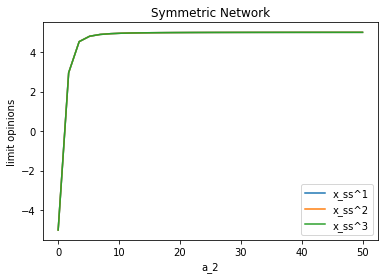

In [22]:
grid = np.linspace(0.0001, 50, 30)
base_1 = [run_simple(A_symmetric, -5, 5, 1, g, print_ = False) for g in grid]
plt.plot(grid, [b[0][0] for b in base_1], label = "x_ss^1")
plt.plot(grid, [b[1][0] for b in base_1], label = "x_ss^2")
plt.plot(grid, [b[2][0] for b in base_1], label = "x_ss^3")
plt.xlabel("a_2")
plt.ylabel("limit opinions")
plt.legend()
plt.title("Symmetric Network")
plt.show()

There appears to be a limit in the perfectly symmetric case. Now if we use the asymmetric case from before:

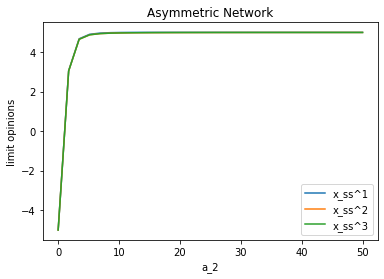

In [23]:
base_2 = [run_simulation(-5, 5, 1, g, print_ = False) for g in grid]
plt.plot(grid, [b[0][0] for b in base_2], label = "x_ss^1")
plt.plot(grid, [b[1][0] for b in base_2], label = "x_ss^2")
plt.plot(grid, [b[2][0] for b in base_2], label = "x_ss^3")
plt.xlabel("a_2")
plt.ylabel("limit opinions")
plt.legend()
plt.title("Asymmetric Network")
plt.show()

If we overlay:

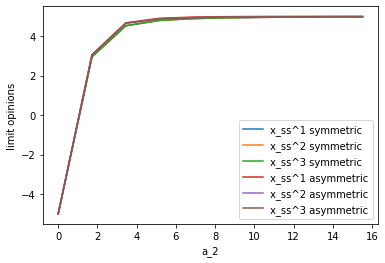

In [24]:
plt.plot(grid[:10], [b[0][0] for b in base_1[:10]], label = "x_ss^1 symmetric")
plt.plot(grid[:10], [b[1][0] for b in base_1[:10]], label = "x_ss^2 symmetric")
plt.plot(grid[:10], [b[2][0] for b in base_1[:10]], label = "x_ss^3 symmetric")
plt.plot(grid[:10], [b[0][0] for b in base_2[:10]], label = "x_ss^1 asymmetric")
plt.plot(grid[:10], [b[1][0] for b in base_2[:10]], label = "x_ss^2 asymmetric")
plt.plot(grid[:10], [b[2][0] for b in base_2[:10]], label = "x_ss^3 asymmetric")
plt.xlabel("a_2")
plt.ylabel("limit opinions")
plt.legend()
plt.show()

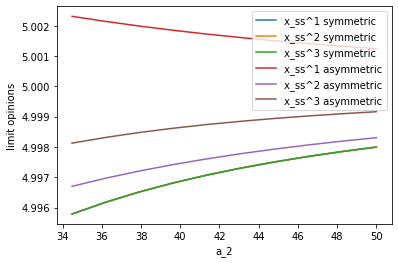

In [25]:
plt.plot(grid[-10:], [b[0][0] for b in base_1[-10:]], label = "x_ss^1 symmetric")
plt.plot(grid[-10:], [b[1][0] for b in base_1[-10:]], label = "x_ss^2 symmetric")
plt.plot(grid[-10:], [b[2][0] for b in base_1[-10:]], label = "x_ss^3 symmetric")
plt.plot(grid[-10:], [b[0][0] for b in base_2[-10:]], label = "x_ss^1 asymmetric")
plt.plot(grid[-10:], [b[1][0] for b in base_2[-10:]], label = "x_ss^2 asymmetric")
plt.plot(grid[-10:], [b[2][0] for b in base_2[-10:]], label = "x_ss^3 asymmetric")
plt.xlabel("a_2")
plt.ylabel("limit opinions")
plt.legend()
plt.show()

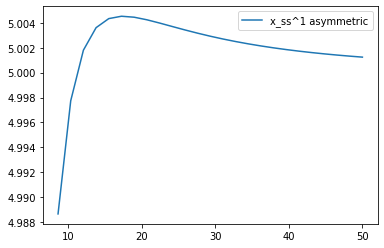

In [26]:
plt.plot(grid[-25:], [b[0][0] for b in base_2[-25:]], label = "x_ss^1 asymmetric")
plt.legend()

This is very odd.

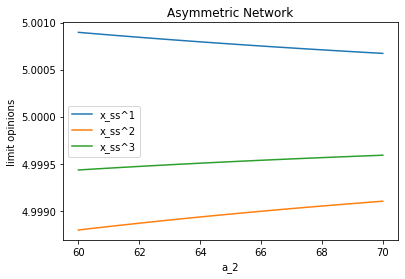

In [27]:
grid3 = np.linspace(60, 70, 30)
base_3 = [run_simulation(-5, 5, 1, g, print_ = False) for g in grid3]
plt.plot(grid3, [b[0][0] for b in base_3], label = "x_ss^1")
plt.plot(grid3, [b[1][0] for b in base_3], label = "x_ss^2")
plt.plot(grid3, [b[2][0] for b in base_3], label = "x_ss^3")
plt.xlabel("a_2")
plt.ylabel("limit opinions")
plt.legend()
plt.title("Asymmetric Network")
plt.show()

The limit as $a_2$ goes to infinity is strategic agent 2's agenda, but the intermediate values are very odd.

In [28]:
run_simulation(-5, 5, 1, 1000)

ASYMMETRIC NETWORK
Steady-State Opinions:
[[5.0000035]
 [4.9999954]
 [4.9999981]]
Average of agendas:
0.0

K^* (1, 2):
[[1.00000003e+00 1.42733246e-08 1.82892478e-08]
 [1.42733246e-08 1.00000001e+00 6.24447951e-09]
 [1.82892478e-08 6.24447951e-09 1.00000002e+00]]
[[1.00015397e+00 6.39856563e-05 8.19816213e-05]
 [6.39856563e-05 1.00002799e+00 2.79937247e-05]
 [8.19816213e-05 2.79937247e-05 1.00006998e+00]]

k^* (1, 2):
[[0.00602432 0.00240973 0.00361459]]
[[-2.70054440e-05 -1.08025681e-05 -1.62015744e-05]]

kappa^* (1, 2):
[[-2712.03350485]]
[[-1.21545443e-05]]


In [29]:
run_simulation(-5, 5, 1000, 1)

ASYMMETRIC NETWORK
Steady-State Opinions:
[[-5.0000035]
 [-4.9999954]
 [-4.9999981]]
Average of agendas:
0.0

K^* (1, 2):
[[1.00015397e+00 6.39856563e-05 8.19816213e-05]
 [6.39856563e-05 1.00002799e+00 2.79937247e-05]
 [8.19816213e-05 2.79937247e-05 1.00006998e+00]]
[[1.00000003e+00 1.42733246e-08 1.82892478e-08]
 [1.42733246e-08 1.00000001e+00 6.24447951e-09]
 [1.82892478e-08 6.24447951e-09 1.00000002e+00]]

k^* (1, 2):
[[2.70054440e-05 1.08025681e-05 1.62015744e-05]]
[[-0.00602432 -0.00240973 -0.00361459]]

kappa^* (1, 2):
[[-1.21545443e-05]]
[[-2712.03350485]]


In [30]:
run_simulation(-5, 5, 0.001, 1)

ASYMMETRIC NETWORK
Steady-State Opinions:
[[4.9999929]
 [4.9999929]
 [4.9999929]]
Average of agendas:
0.0

K^* (1, 2):
[[5.21556479 1.81677405 1.96363031]
 [1.81677405 1.78942114 0.81831451]
 [1.96363031 0.81831451 2.03577453]]
[[6.42786721 2.34281075 2.51284358]
 [2.34281075 2.01770576 1.05650012]
 [2.51284358 1.05650012 2.2851345 ]]

k^* (1, 2):
[[45.75110679 19.85016436 20.7352036 ]]
[[-5.90398047e-05 -2.56169394e-05 -2.67528069e-05]]

kappa^* (1, 2):
[[-312.81505181]]
[[-3.56347462e-10]]


In [31]:
run_simulation(-5, 5, 1, 0.001)

ASYMMETRIC NETWORK
Steady-State Opinions:
[[-4.99998851]
 [-4.99998837]
 [-4.99998839]]
Average of agendas:
0.0

K^* (1, 2):
[[6.42786721 2.34281075 2.51284358]
 [2.34281075 2.01770576 1.05650012]
 [2.51284358 1.05650012 2.2851345 ]]
[[5.21556479 1.81677405 1.96363031]
 [1.81677405 1.78942114 0.81831451]
 [1.96363031 0.81831451 2.03577453]]

k^* (1, 2):
[[5.90398047e-05 2.56169394e-05 2.67528069e-05]]
[[-45.75110679 -19.85016436 -20.7352036 ]]

kappa^* (1, 2):
[[-3.56347462e-10]]
[[-312.81505181]]


Limit-wise, the opposite of the infinity case occurs when one of the weights is brought to zero, which is also intuitive.

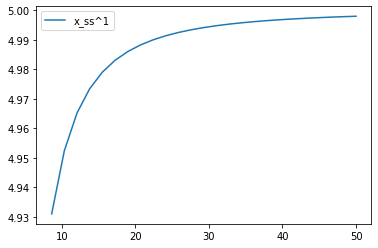

In [32]:
A_stubborn = np.array([ # this is symmetric
    [0.9, 0.07, 0.03],
    [0.07, 0.58, 0.35],
    [0.03, 0.35, 0.62]
])
plt.plot(grid[-25:], [b[0][0] for b in [run_simple(A_stubborn, -5, 5, 1, g, delta = 0.5, print_ = False) for g in grid][-25:]], label = "x_ss^1")
plt.legend()

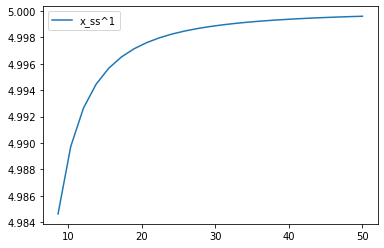

In [33]:
plt.plot(grid[-25:], [b[0][0] for b in [run_simple(A_stubborn, -5, 5, 1, g, delta = 0.9, print_ = False) for g in grid][-25:]], label = "x_ss^1")
plt.legend()

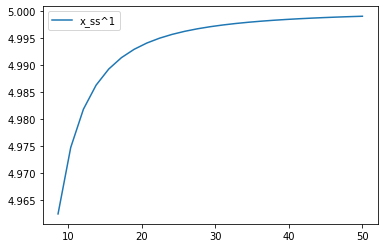

In [34]:
A_stubborn_asymmetric = np.array([ # asymmetric
    [0.6, 0.3, 0.1],
    [0.4, 0.1, 0.5],
    [0.5, 0.2, 0.3]
])
plt.plot(grid[-25:], [b[0][0] for b in [run_simple(A_stubborn_asymmetric, -5, 5, 1, g, delta = 0.5, print_ = False) for g in grid][-25:]], label = "x_ss^1")
plt.legend()

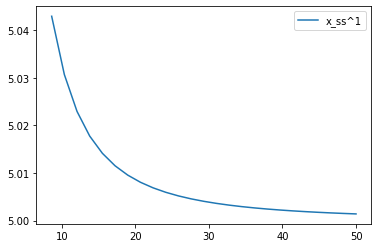

In [35]:
plt.plot(grid[-25:], [b[0][0] for b in [run_simple(A_stubborn_asymmetric, -5, 5, 1, g, delta = 0.9, print_ = False) for g in grid][-25:]], label = "x_ss^1")
plt.legend()

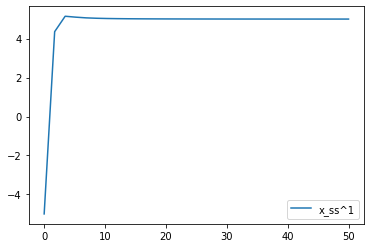

In [36]:
plt.plot(grid, [b[0][0] for b in [run_simple(A_stubborn_asymmetric, -5, 5, 1, g, delta = 0.9, print_ = False) for g in grid]], label = "x_ss^1")
plt.legend()

The behaviour occurs with high $\delta$ in the asymmetric case.